## 00. Import libraries and load data

Note: This Jupyter Notebook was created as part of the group work. Each member has contributed similarly to the result.

In [33]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline

## 1. Read in the data

In [34]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed_unscaled.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 10)

In [35]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y = df["Promotion"]
X = df.loc[:, ~df.columns.isin(['Promotion', 'Product_UID'])]

In [36]:
# We check if y equals the attribute we want to predict (Promotion)
y

0       0
1       1
2       1
3       0
4       0
       ..
1717    0
1718    1
1719    0
1720    0
1721    1
Name: Promotion, Length: 1722, dtype: int64

In [37]:
# We check if X equals all other attributes than Promotion to predict this attribute 
X

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Demand,Weekday
0,1,1,195,72.72,5,1,115,2
1,0,1,117,80.16,15,1,229,2
2,0,1,247,62.94,10,1,157,2
3,1,1,139,87.63,10,1,52,2
4,3,1,152,54.41,0,1,59,2
...,...,...,...,...,...,...,...,...
1717,3,1,129,62.83,10,0,143,5
1718,2,1,104,98.97,10,0,54,5
1719,2,1,494,111.25,10,0,70,5
1720,3,2,625,69.62,5,1,69,5


# 2. Split the data with Split Validation

In [38]:
# We check the imbalance of the data set to get further information for potential data augmentation techniques
y.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [39]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape
print("Before:", Counter(y_train))

Before: Counter({0: 743, 1: 410})


## 2.4 Entropy - SMOTE

In [40]:
# We set the paramters to the best paramters we have derived before 
best_params_entropy = {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}

In [41]:
# We will use SMOTE in combination with RandomUndersampling to generate synthetic data points which will adjust the class imbalance and will increase the performance of the model
# To get the best SMOTE strategy, best SMOTE ratio of Minority to Majority class and the best Undersampling Ratio, we iterate through all possible combinations with for loops
# To calculate the accuracy score, we will use the best parameters that we have derived before
# We store the best strategy with the best ratio to use them for further analysis 
# To always keep the right order of undersampling and SMOTE and prevent data leakage we use a pipeline
best_score = 0
best_variant = None
best_ratio = None
best_ratio_under = None

smote_variants = {
    'SMOTE': SMOTE,
    'BorderlineSMOTE': BorderlineSMOTE,
    'KMeansSMOTE': KMeansSMOTE,
    'SVMSMOTE': SVMSMOTE
}

smote_ratio = [i / 100 for i in range(35, 101)]
undersampling_ratio = [i / 100 for i in range(1, 101)]
for smote_strat, smote_class in smote_variants.items(): 
    for ratio_under in undersampling_ratio: 
        for ratio in smote_ratio: 
            try:
                pipeline = Pipeline([
                    ('under', RandomUnderSampler(sampling_strategy=ratio_under, random_state=42)),
                    ('smote', smote_class(sampling_strategy=ratio, random_state=42))
                ])
                
                X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

                # Train and evaluate
                dt_gini = DecisionTreeClassifier(criterion='gini', splitter='best', **best_params_entropy, random_state=42)
                dt_gini.fit(X_train_resampled, y_train_resampled)
                y_pred = dt_gini.predict(X_test)
                acc = accuracy_score(y_test, y_pred)

                if acc > best_score:
                    best_score = acc
                    best_variant = smote_class
                    best_ratio = ratio
                    best_ratio_under = ratio_under
            except ValueError as e:
                continue
            except RuntimeError as e:
                if "No clusters found" in str(e):
                    continue
                else:
                    raise e
# Print best result
print(f"\nBest accuracy: {best_score:.4f} with variant: {best_variant.__name__}, "
      f"SMOTE ratio: {best_ratio}, undersampling ratio: {best_ratio_under}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p


Best accuracy: 0.9086 with variant: BorderlineSMOTE, SMOTE ratio: 0.94, undersampling ratio: 0.84


In [42]:
# We use the best variant and ratios to resample our training data 
# Undersample
under = RandomUnderSampler(sampling_strategy=best_ratio_under, random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
print("After undersampling:", Counter(y_train_under))

# SMOTE (or the best variant)
smote = best_variant(sampling_strategy=best_ratio, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_under, y_train_under)
print("After SMOTE:", Counter(y_train_smote))

After undersampling: Counter({0: 488, 1: 410})
After SMOTE: Counter({0: 488, 1: 458})


In [43]:
# We build the tree and calculate the accuracy for the entropy based tree with the best paramters and the best SMOTE strategy with the best ratio 
dt_entropy = DecisionTreeClassifier(criterion='entropy', splitter='best', **best_params_entropy, random_state=42)
dt_entropy.fit(X_train_smote, y_train_smote)
y_pred_entropy = dt_entropy.predict(X_test)
accuracy_test_entropy_smote = accuracy_score (y_test, y_pred_entropy)
print(accuracy_test_entropy_smote)

0.9086115992970123


In [44]:
# We want to check wether our model is robust or if it is dependant on the data. The only way to check is to 
# evaluate the accuracy based on the train data and compare the results with the accuracy of the test data. If they
# deviate less than 5%, the model is independant of the underlying data structure and thus is robust
y_pred_train_entropy = dt_entropy.predict(X_train_smote)
accuracy_train_entropy_smote = accuracy_score(y_train_smote, y_pred_train_entropy)
print(accuracy_train_entropy_smote)
if abs(accuracy_test_entropy_smote-accuracy_train_entropy_smote) < (0.05*accuracy_test_entropy_smote): 
    print("Passed the Robustness Check!")
else: 
    print("Didn't pass the Robustness Check!")

0.9027484143763214
Passed the Robustness Check!


[Text(0.6, 0.875, 'Discount <= 10.5\nentropy = 0.999\nsamples = 946\nvalue = [488.0, 458.0]\nclass = No Promotion'),
 Text(0.4, 0.625, 'Discount <= 7.5\nentropy = 0.709\nsamples = 605\nvalue = [488, 117]\nclass = No Promotion'),
 Text(0.5, 0.75, 'True  '),
 Text(0.2, 0.375, 'entropy = 0.0\nsamples = 325\nvalue = [325, 0]\nclass = No Promotion'),
 Text(0.6, 0.375, 'Demand <= 144.5\nentropy = 0.98\nsamples = 280\nvalue = [163, 117]\nclass = No Promotion'),
 Text(0.4, 0.125, 'entropy = 0.92\nsamples = 215\nvalue = [143, 72]\nclass = No Promotion'),
 Text(0.8, 0.125, 'entropy = 0.89\nsamples = 65\nvalue = [20, 45]\nclass = Promotion'),
 Text(0.8, 0.625, 'entropy = 0.0\nsamples = 341\nvalue = [0, 341]\nclass = Promotion'),
 Text(0.7, 0.75, '  False')]

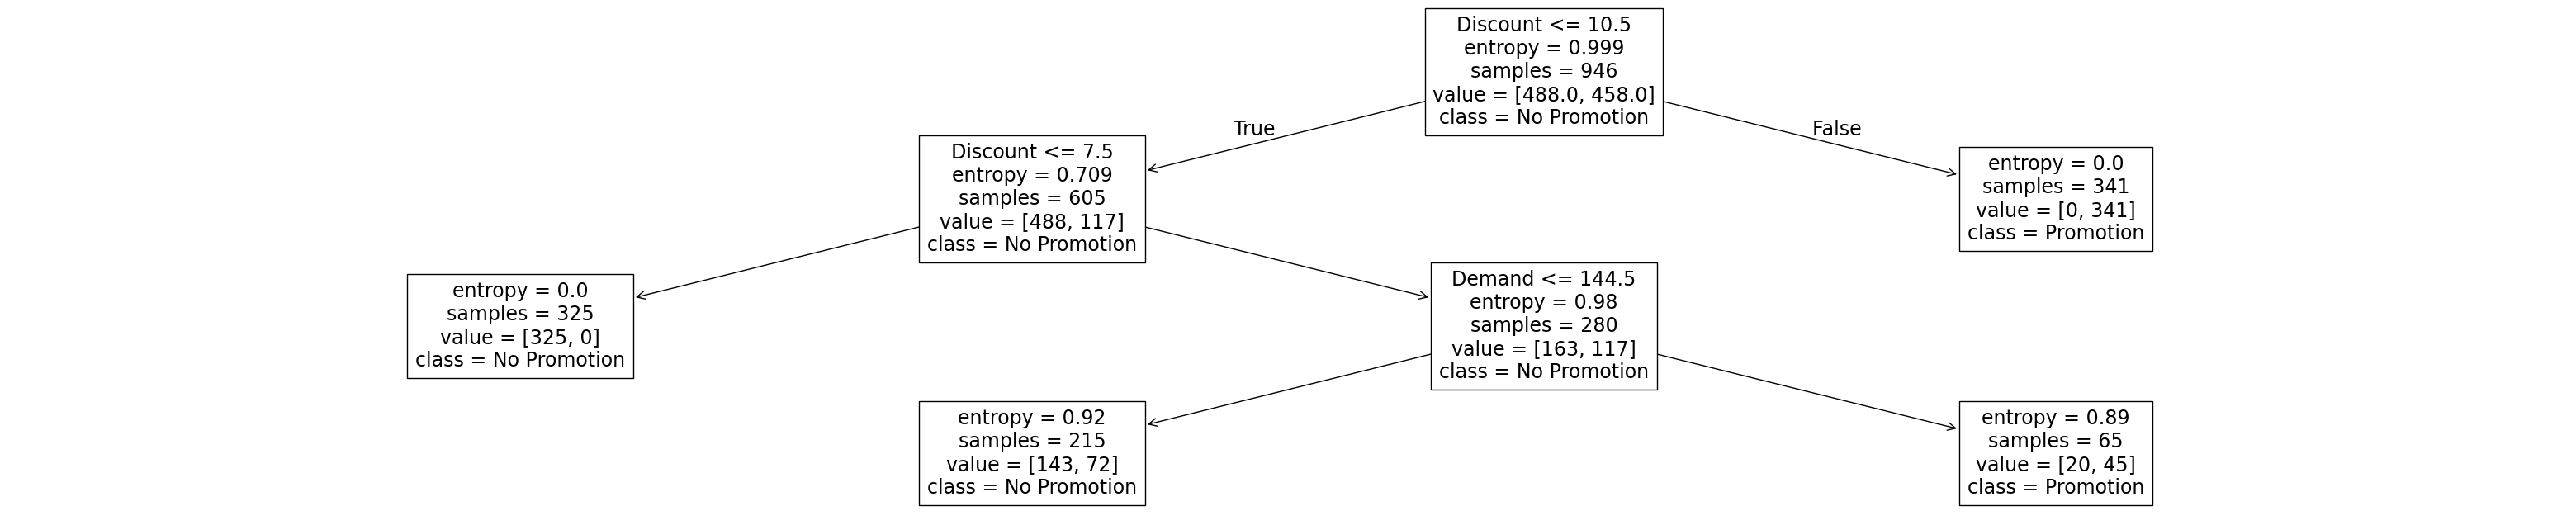

In [45]:
# We plot the decision tree to check if our model is interpretable. 
feature_names = X_train.columns
plt.figure(figsize=(40,8))
tree.plot_tree(dt_entropy.fit(X_train_smote, y_train_smote),feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

In [46]:
# We can also get our rules in textual format
feature_names = X_train.columns
text_representation = tree.export_text(dt_entropy, feature_names=feature_names)
print(text_representation)

|--- Discount <= 10.50
|   |--- Discount <= 7.50
|   |   |--- class: 0
|   |--- Discount >  7.50
|   |   |--- Demand <= 144.50
|   |   |   |--- class: 0
|   |   |--- Demand >  144.50
|   |   |   |--- class: 1
|--- Discount >  10.50
|   |--- class: 1



Text(0.5, 1.0, 'Confusion Matrix')

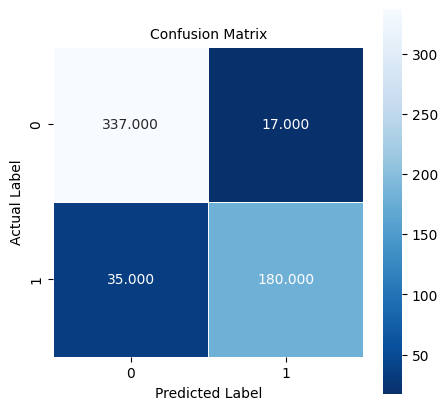

In [47]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_entropy)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [48]:
# We analyze the classification report to get further insights in the performance of our model
print(classification_report(y_test, y_pred_entropy))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       354
           1       0.91      0.84      0.87       215

    accuracy                           0.91       569
   macro avg       0.91      0.89      0.90       569
weighted avg       0.91      0.91      0.91       569

